In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import signal
from scipy.io import wavfile
import numpy as np
from IPython.display import Audio, clear_output

Generisanje audio signala

In [2]:
F1 = 200
F2 = 400
F3 = 500
F4 = 700
Fs = 11025
t0 = 0.5
t = np.arange(0,t0,1./Fs)
x1 = np.sin(2 * np.pi * F1 * t )
x2 = np.sin(2 * np.pi * F2 * t )
x3 = np.sin(2 * np.pi * F3 * t )
x4 = np.sin(2 * np.pi * F4 * t )

x = np.concatenate((x1,x2,x3,x4))
x = x / np.max(np.abs(x))
#dopunjen nulama do 3 sekunde
input_signal = np.zeros(11025*3)
input_signal[:x.size] = x


wavfile.write("input_signal.wav", Fs, input_signal.astype(np.float16)) 

Audio(input_signal,rate = Fs)

Funkcija za upis u header

In [3]:
def create_c_header(input_signal, filename, sample_rate):
    # Otvaranje datoteke za upis
    with open(filename, 'w') as header_file:
        header_file.write('#ifndef AUDIO_DATA_H_\n')
        header_file.write('#define AUDIO_DATA_H_\n\n')

        # Definisanje frekvencije odmjeravanja
        header_file.write(f'#define SAMPLE_RATE {sample_rate}\n\n')

        # Definisanje duzine niza
        header_file.write(f'#define AUDIO_DATA_LENGTH {len(input_signal)}\n\n')

        # Upis niza podataka ulaznog signala
        header_file.write('float audio_data[] = {\n    ')
        for i, sample in enumerate(input_signal):
            header_file.write(f'{sample:.8f}, ')
            if (i + 1) % 10 == 0:  # nakon svakih 10 uzoraka nova linija
                header_file.write('\n    ')  
            
        header_file.write('\n};\n')

        header_file.write('#endif // AUDIO_DATA_H_\n')


In [4]:
filename = "audio_data.h"
create_c_header(input_signal, filename, sample_rate=Fs)

Funkcije za iscrtavanje signala

In [5]:
def plotSignals(input_signal,output_signal):
    figure(num=None,figsize=(18,4))
    #t = np.arange( len(input_signal)) / Fs
    plt.plot(input_signal,label="Originalni signal",color="blue")
    plt.plot(output_signal,label="Signal sa efektom",color="orange")
    plt.legend()
    plt.show()

Funkcija za prikaza greske signala

In [6]:
def signal_error(audio_py, audio_C):
    error  = np.abs(audio_py-audio_C)
    plt.figure()
    plt.plot(error)
    plt.title("Signal greske")
    plt.show()

Funkcija za čitanje binarnog fajla iz C-a

In [7]:
def read_from_C(filename):
    #otvaranje binarne datoteke za citanje
    with open(filename,'rb') as file:
        audio_data = file.read()  #audio odmjerci u bajtovima
    #konverzija bajtova y NumPy niz
    audio_samples = np.frombuffer(audio_data,dtype=np.float32)
    
    return audio_samples

Delay sa feedback petljom implementiran na principu dijagrama prikazanog ispod:

![](basic_delay_unit_with_feedback.png)

In [36]:
def delay_with_feedback(input_signal, Fs,delay_ms, feedback_gain, feedforward_gain,outputfile):
    """
    Funkcija kreira eho efekat(delay with feedback) nad ulaznim audio signalom. 

    Ulazni parametri:
    input_signal    - Ulazni signal(niz odmjeraka)
    Fs              - Frekvencija odmjeravanja u Hz
    delay_ms        - Kasnjenje u milisekundama
    feedback_gain   - Pojacanje zakasnjenog signala u povratnoj petlji
    feedforward_gain- Pojacanje zakasnjenog signala koji se sabira sa ulaznim
    outputfile      - Naziv izlaznog fajla.
    
    return:
    Izlazni signal nad kojim je primijenjen echo efekat
    """
    delay_samples = int(Fs* (delay_ms/1000.0))
    
    output_signal = np.zeros_like(input_signal)

    buffer = np.zeros(delay_samples)
    for n in range(len(input_signal)):
    
        input_sample = input_signal[n]

        delayed_sample = buffer[n % delay_samples]

        if n < delay_samples:
            output_signal[n] = input_sample
        else:
            
            buffer[n % delay_samples] = input_sample + feedback_gain * delayed_sample

            output_signal[n] = input_sample + feedforward_gain * delayed_sample

    output_signal = output_signal / np.max(np.abs(output_signal))

    wavfile.write(outputfile,Fs,output_signal.astype(np.int16))

    return output_signal



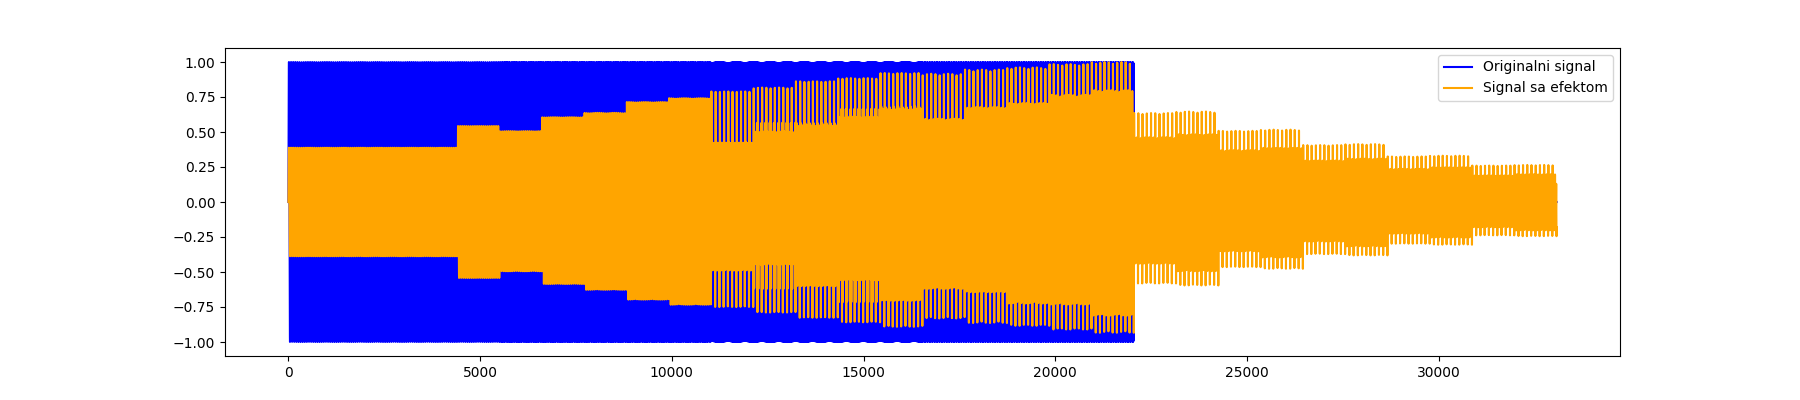

In [9]:
delay_with_feedback = delay_with_feedback(input_signal, Fs, 200.0, 0.8, 0.4,"output_delay_feedback.wav")
plotSignals(input_signal,delay_with_feedback)
Audio(delay_with_feedback,rate=Fs)

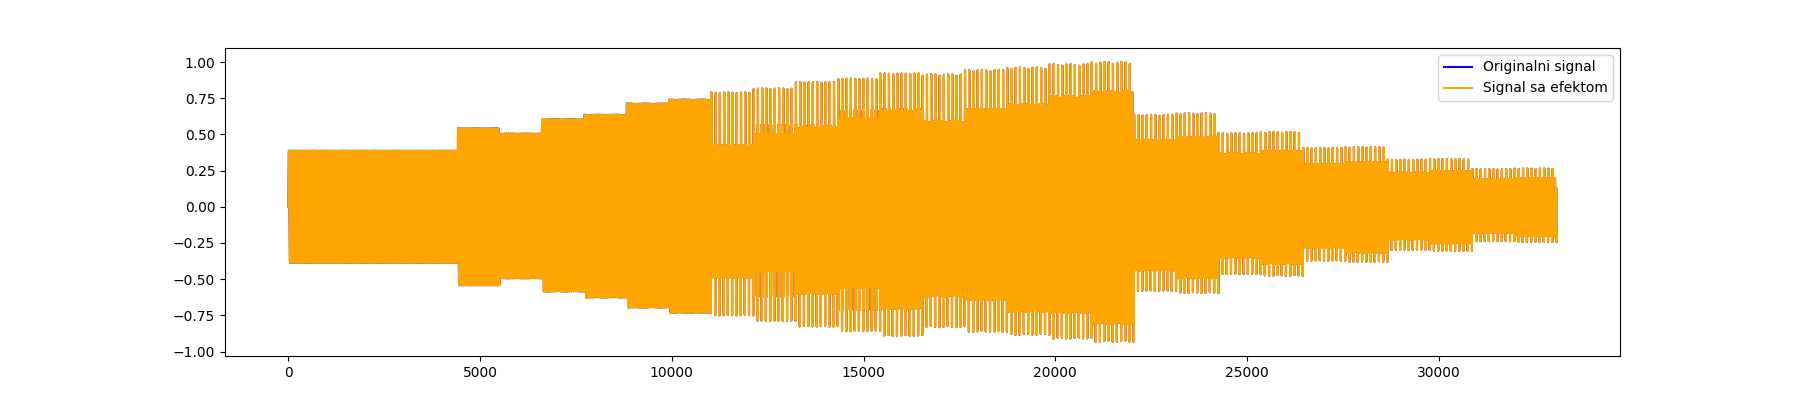

In [10]:
delay_with_feedback_c = read_from_C("output_delay_with_feedback_c.bin")
plotSignals(delay_with_feedback,delay_with_feedback_c)
Audio(delay_with_feedback_c,rate=Fs)

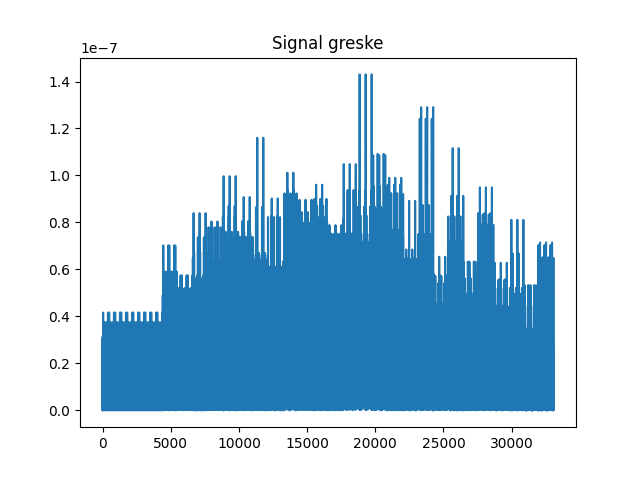

In [11]:
signal_error(delay_with_feedback,delay_with_feedback_c)

Tremolo

![](tremolo.png)

In [39]:
def tremolo(input_signal,Fs,Flfo,alpha,output_file):
        """
        Ulazni parametri:
        input_signal    -   Ulazni audio signal
        Fs              -   Frekvencija oscilovanja u Hz
        Flfo            -   Frekvencija modulacije (<20Hz)
        alpha (float)   -   Faktor dubine modulacije, ukazuje koliiko ce amplitudna modulacija uticati na amplitudu originalnog signala,izmedju 0 i 1
        output_file     -   Izlazni fajl u koji ce biti smjesten audio signal nad kojim je primijenjen efekat
        
        :returns:       - Izlazni audio signal nad kojim je primijenjen efekat
        
        """
        y = np.zeros(len(input_signal))
        for i in range(len(input_signal)):
            m = (1+alpha*np.sin(2*np.pi*i*(Flfo/Fs)))
            y[i] = m * input_signal[i]
        
        y = y/np.max(np.abs(y)) 

        wavfile.write(output_file,Fs,y.astype(np.int16))
        return y


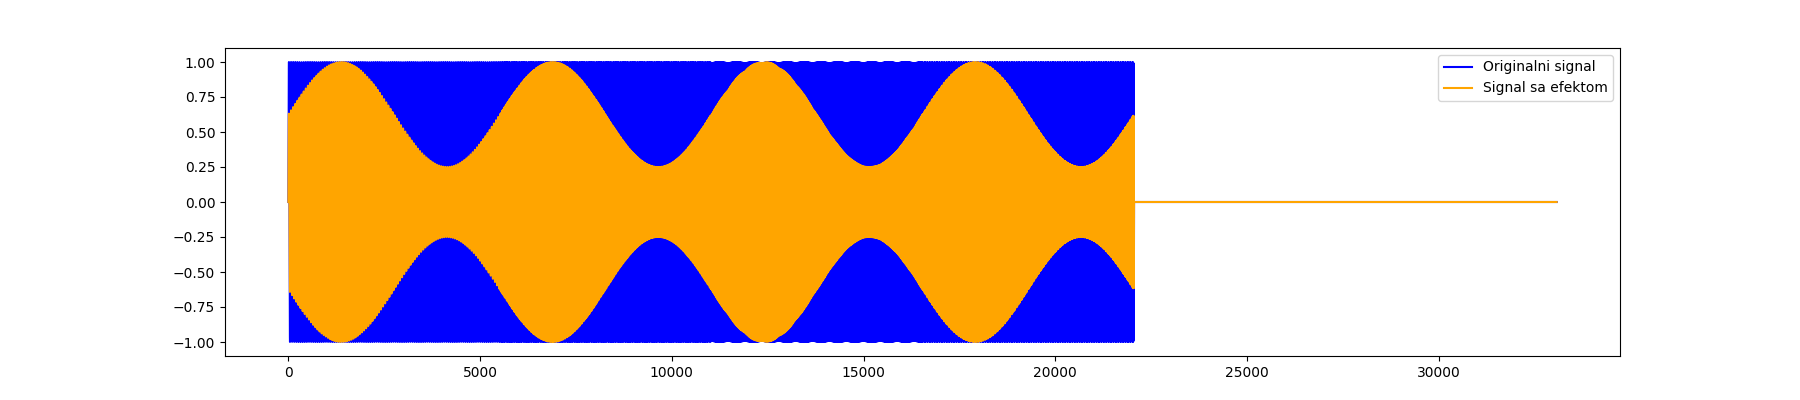

In [13]:
tremolo =tremolo(input_signal,Fs,2,0.6,"output_tremolo.wav")
plotSignals(input_signal,tremolo)
Audio(tremolo,rate=Fs)

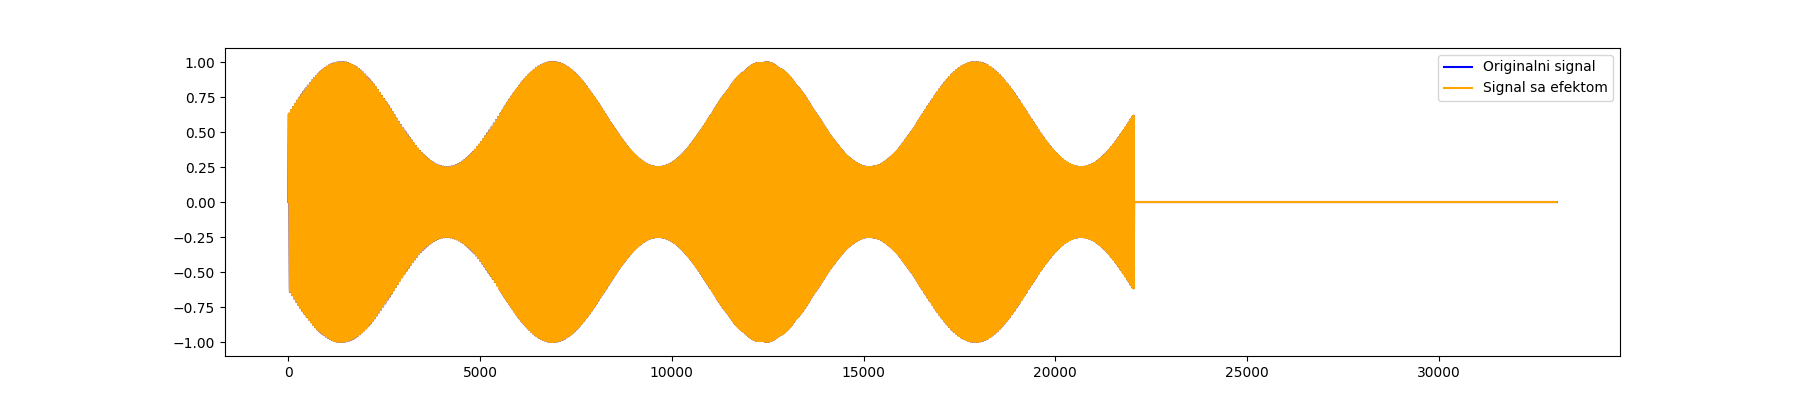

In [14]:
tremolo_c = read_from_C("output_tremolo_c.bin")
plotSignals(tremolo,tremolo_c)
Audio(tremolo_c,rate=Fs)

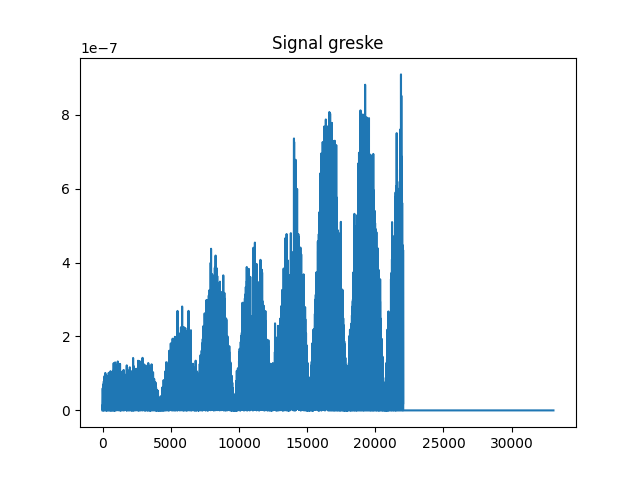

In [15]:
signal_error(tremolo,tremolo_c)

Flanger 

![](basic_flanger_without_feedback.png)

In [42]:
def flanger(input_signal, Fs,Flfo,delay_ms, gain,output_file):
    """
    Primjena flanger efekta na ulazni audio signal

    Ulazni parametri:
    input_signal -   ulazni audio signal
    Fs           -   frekvencija odmjeravanja (Hz)
    Flfo         -   frekvencija oscilatora (~1Hz)                
    delay_ms     -   maksimalno željeno kašnjenje u milisekundama(0-15ms)
    gain         -   pojačanje, od 0 do 1     
    
    Return:      
    Audio signal sa primijenjenim flanger efektom, normalizovan.
    """
    output_signal = np.zeros(len(input_signal))
    omega = 2 * np.pi * Flfo / Fs
    delay_samples = int(Fs * (delay_ms / 1000.0))   # maksimalno kasnjenje u odmjercima
    for i in range(len(input_signal)):
        d = delay_samples * 0.5 * (1 + np.sin(i * omega))  
        d_int = int(d)  
        frac = d - d_int  

        if i - d_int - 1 >= 0:
            delayed_sample = input_signal[i - d_int] * (1 - frac) + input_signal[i - d_int - 1] * frac
            output_signal[i] = input_signal[i] + (gain * delayed_sample)
        else:
            output_signal[i] = input_signal[i]

    output_signal = output_signal / np.max(np.abs(output_signal))

    wavfile.write(output_file,Fs,output_signal.astype(np.int16))

    return output_signal



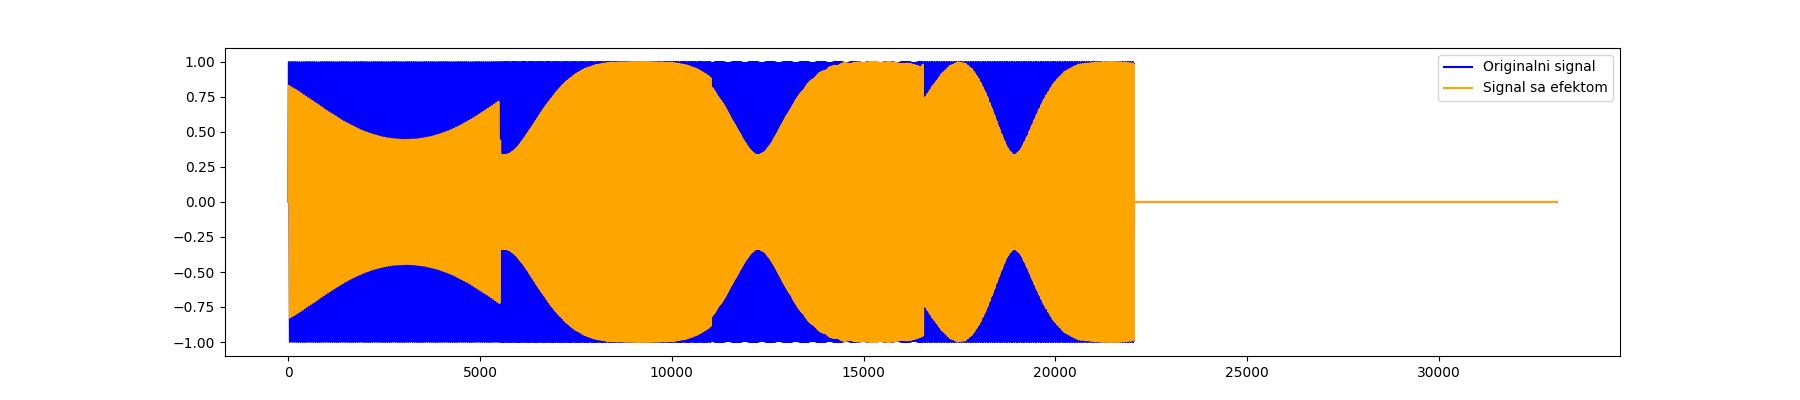

In [17]:
flanger = flanger(input_signal,Fs,0.9,2,0.5,"output_flanger.wav")
plotSignals(input_signal,flanger)
Audio(flanger,rate=Fs)

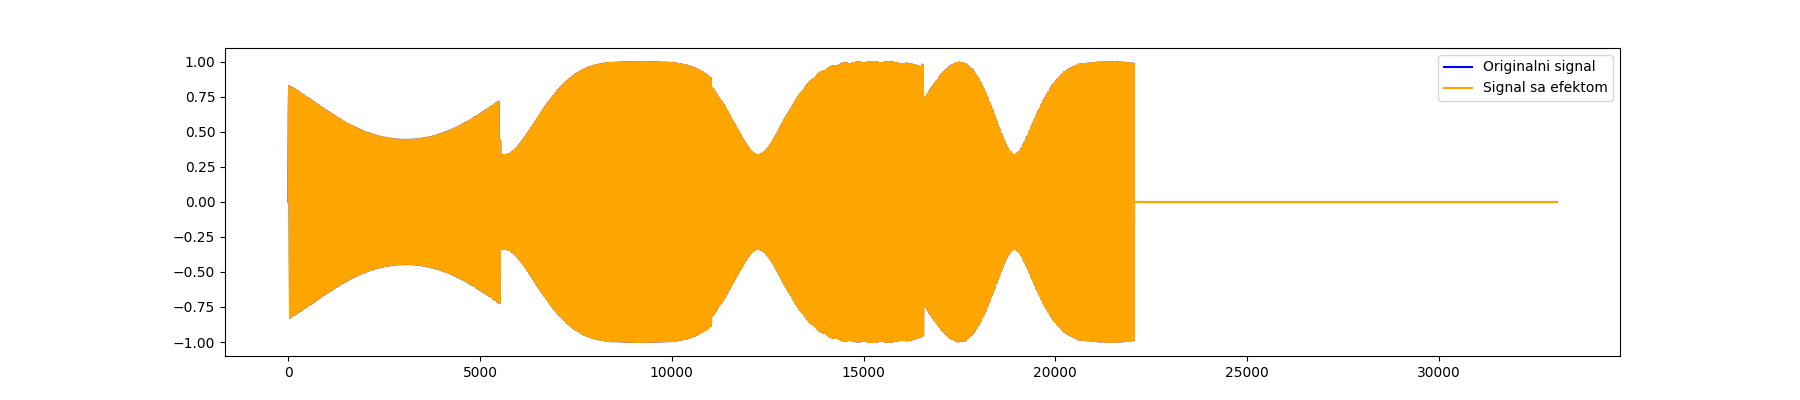

In [18]:
flanger_c = read_from_C("output_flanger_c.bin")
plotSignals(flanger,flanger_c)
Audio(flanger_c,rate=Fs)

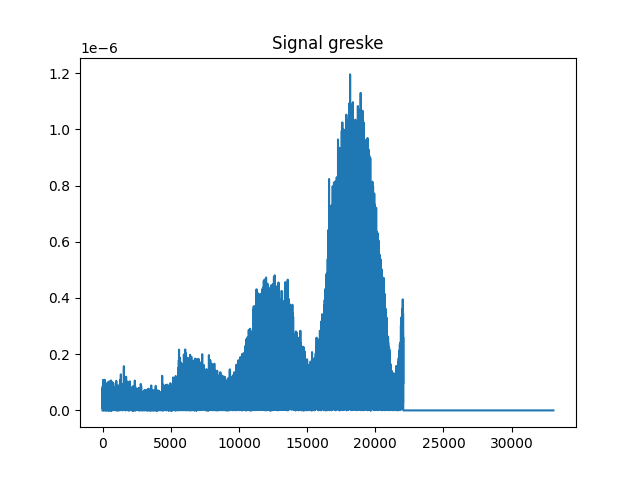

In [19]:
signal_error(flanger,flanger_c)

Flanger with feedback

![](flanger_with_feedback.png)

In [44]:
def flanger_with_feedback(input_signal, Fs, max_delay_ms, rate, feedback_gain, feedforward_gain,output_file):
    """
    Funkcija kreira flanger efekat nad ulaznim audio signalom. 

    Ulazni parametri:
    input_signal     - Ulazni signal (niz odmjeraka)
    Fs               - Frekvencija odmjeravanja u Hz
    max_delay_ms     - Maksimalno kašnjenje u milisekundama
    rate             - Frekvencija LFO-a
    feedback_gain    - Pojačanje zakasnjenog signala u povratnoj petlji
    feedforward_gain - Pojačanje zakasnjenog signala koji se sabira sa ulaznim
    output_file      - Izlazni .wav fajl u koji se smijesta izlazni signal nad kojim je primijenjen efekat
    
    return:
    Izlazni signal nad kojim je primijenjen flanger efekat
    """
    max_delay_samples = int(Fs * (max_delay_ms / 1000.0))
    
  
    buffer = np.zeros(max_delay_samples)
    output_signal = np.zeros_like(input_signal)


    omega = (2 * np.pi * rate) / Fs

    for n in range(len(input_signal)):

        current_delay = (1 + np.sin(omega * n)) / 2  * max_delay_samples
        current_delay = int(current_delay)


        delayed_sample = buffer[n % max_delay_samples]


        buffer[n % max_delay_samples] = input_signal[n] + feedback_gain * delayed_sample


        output_signal[n] = input_signal[n] + feedforward_gain * delayed_sample

    output_signal = output_signal / np.max(np.abs(output_signal))
    
    wavfile.write(output_file,Fs,output_signal.astype(np.int16))

    return output_signal


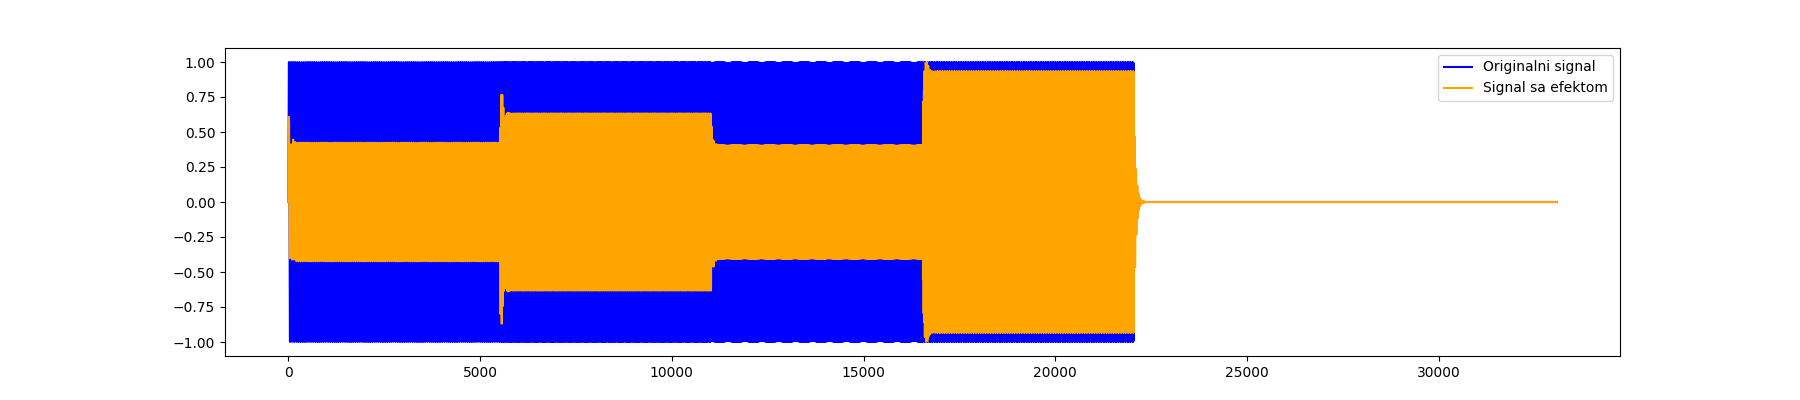

In [21]:
flanger_feedback = flanger_with_feedback(input_signal,Fs,3,0.9,0.5,0.5,"output_flanger_with_feedback.wav")
plotSignals(input_signal,flanger_feedback)
Audio(flanger_feedback,rate=Fs)

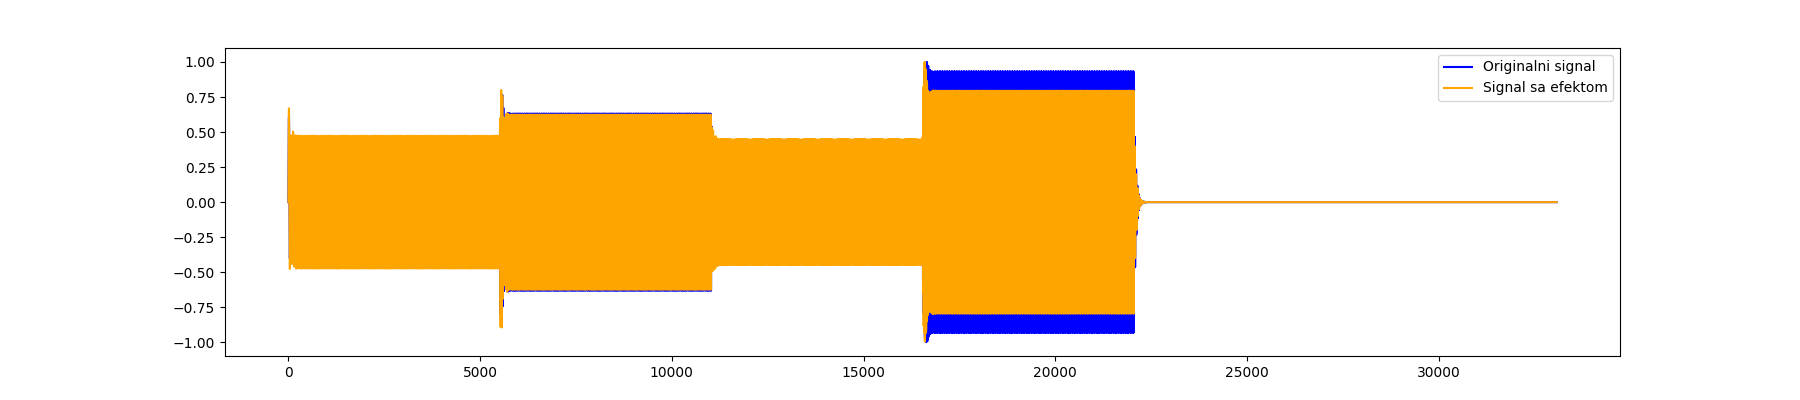

In [22]:
flanger_feedback_c = read_from_C("output_flanger_with_feedback_c.bin")
plotSignals(flanger_feedback,flanger_feedback_c)
Audio(flanger_feedback_c,rate=Fs)

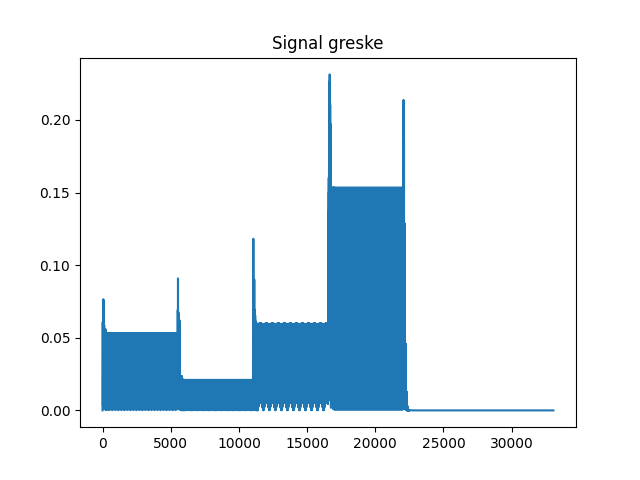

In [46]:
signal_error(flanger_feedback,flanger_feedback_c)

WahWah

In [47]:
def wahwah(input_signal,output_file):
    damp = 0.05  
    minf = 500 
    maxf = 3000 
    Fw = 2000  

    delta = Fw / Fs

    Fc = np.arange(minf, maxf, delta)
    while len(Fc) < len(input_signal):
        Fc = np.append(Fc, np.arange(maxf, minf, -delta))
        Fc = np.append(Fc, np.arange(minf, maxf, delta))
    Fc = Fc[:len(input_signal)]  


    Q1 = 2 * damp
    yh = np.zeros(len(input_signal))
    yb = np.zeros(len(input_signal))
    yl = np.zeros(len(input_signal))

    yh[0] = input_signal[0]
    yb[0] = 2 * np.sin((np.pi * Fc[0]) / Fs) * yh[0]
    yl[0] = 2 * np.sin((np.pi * Fc[0]) / Fs) * yb[0]

    for i in range(1, len(input_signal)):
        F1 = 2 * np.sin((np.pi * Fc[i]) / Fs)
        yh[i] = input_signal[i] - yl[i-1] - Q1 * yb[i-1]
        yb[i] = F1 * yh[i] + yb[i-1]
        yl[i] = F1 * yb[i] + yl[i-1]

    
    yb = yb / np.max(np.abs(yb))

    wavfile.write(output_file,Fs,yb.astype(np.int16))
    return yb


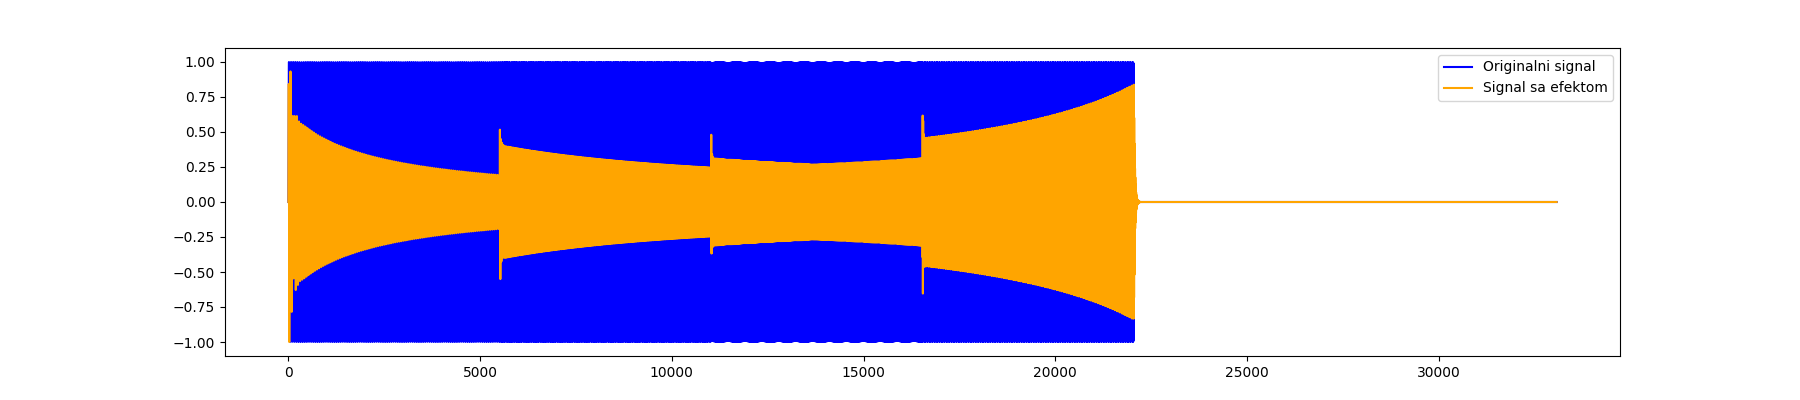

In [25]:
wahwah = wahwah(input_signal,"output_wahwah.wav")
plotSignals(input_signal,wahwah)
Audio(wahwah,rate=Fs)

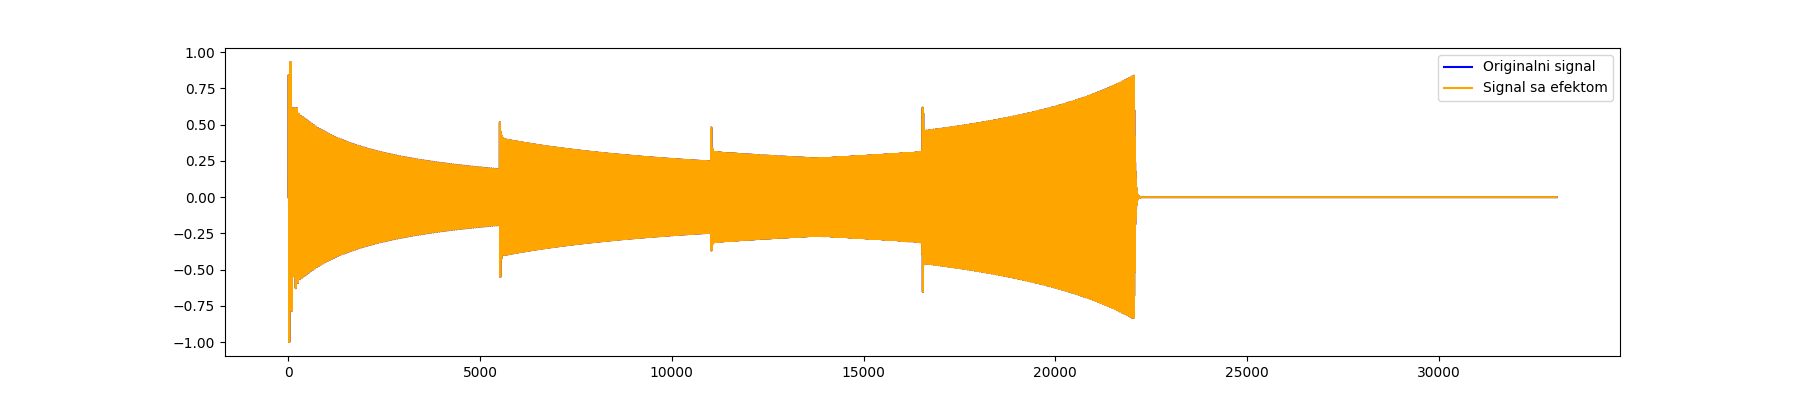

In [26]:
wahwah_c = read_from_C("output_wahwah_c.bin")
plotSignals(wahwah,wahwah_c)
Audio(wahwah_c,rate=Fs)

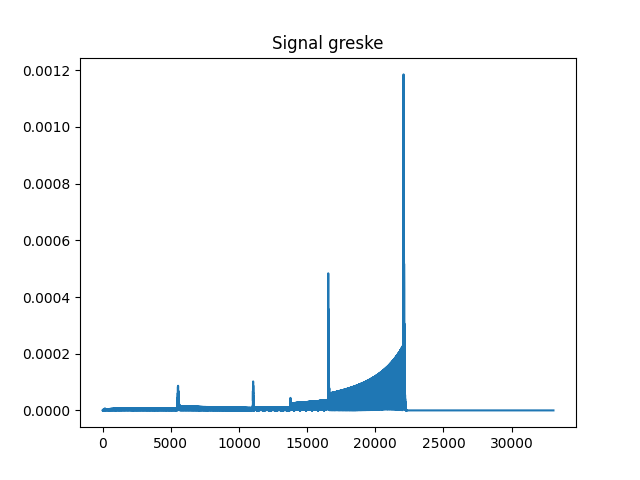

In [27]:
signal_error(wahwah,wahwah_c)

## DRUGI PRIMJER

Učitavanje audio signala


In [32]:
input_audio_file = "acoustic.wav"
samplerate, input = wavfile.read(input_audio_file)
input = input / np.max(np.abs(input))
Audio(input,rate=samplerate)

In [33]:
filename = "acoustic_.h"
create_c_header(input, filename, sample_rate=samplerate)

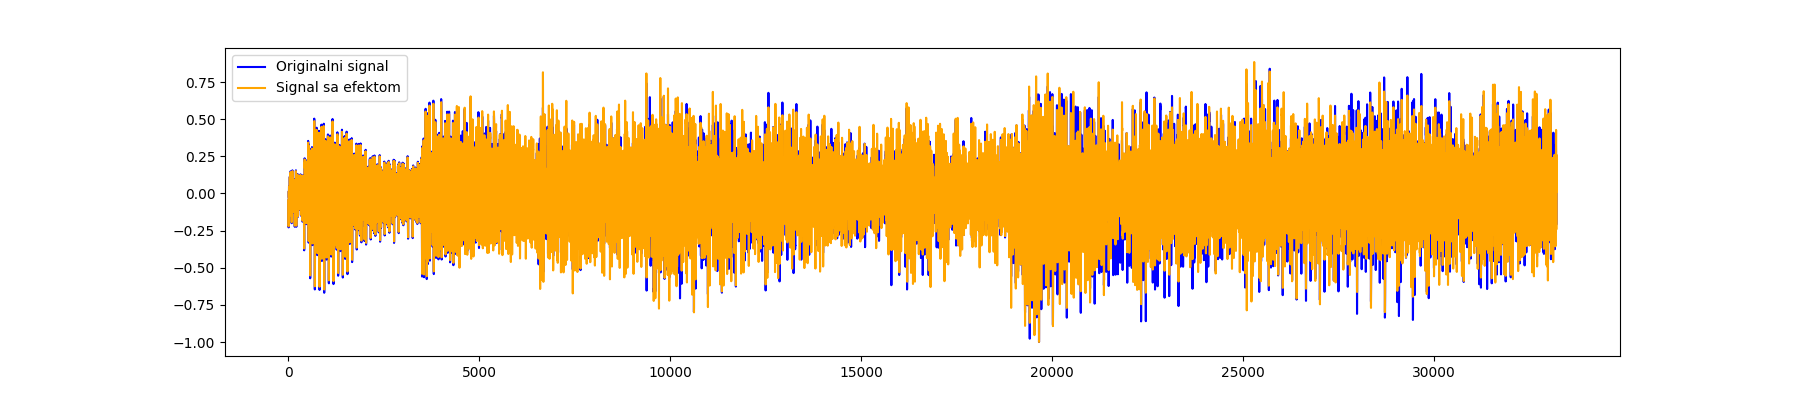

In [37]:
acoustic_delay_with_feedback = delay_with_feedback(input, samplerate, 200, 0.8, 0.4,"acoustic_output_delay_feedback.wav")
plotSignals(input,acoustic_delay_with_feedback)
Audio(acoustic_delay_with_feedback,rate=samplerate)

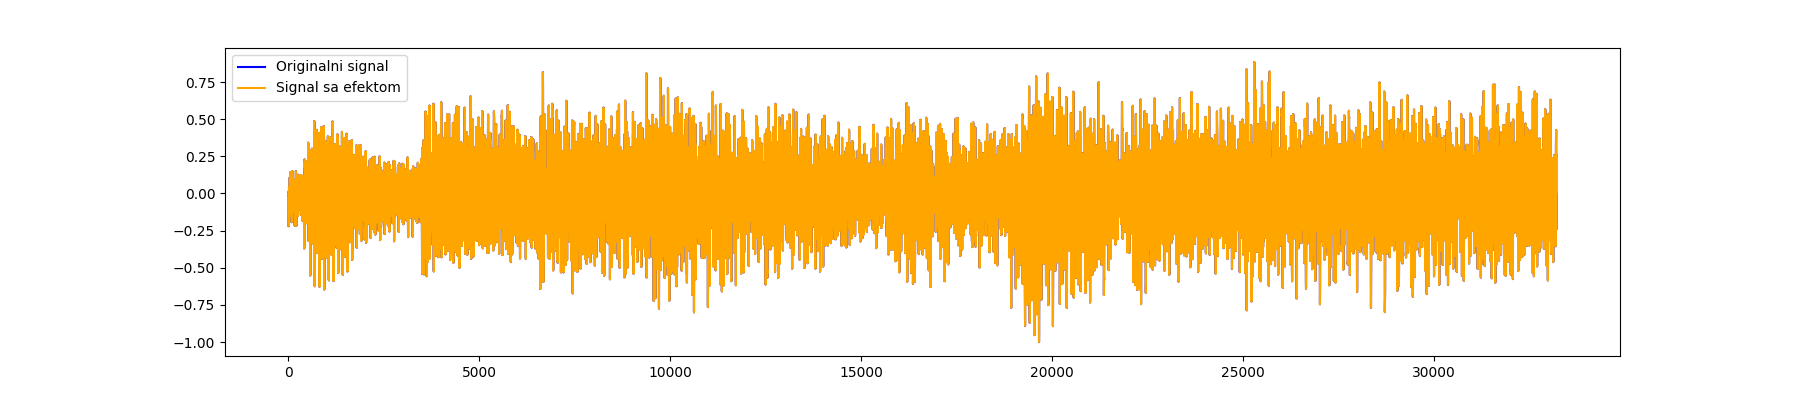

In [52]:
acoustic_delay_with_feedback_c = read_from_C("acoustic_output_delay_with_feedback_c.bin")
plotSignals(acoustic_delay_with_feedback,acoustic_delay_with_feedback_c)
Audio(acoustic_delay_with_feedback_c,rate=samplerate)

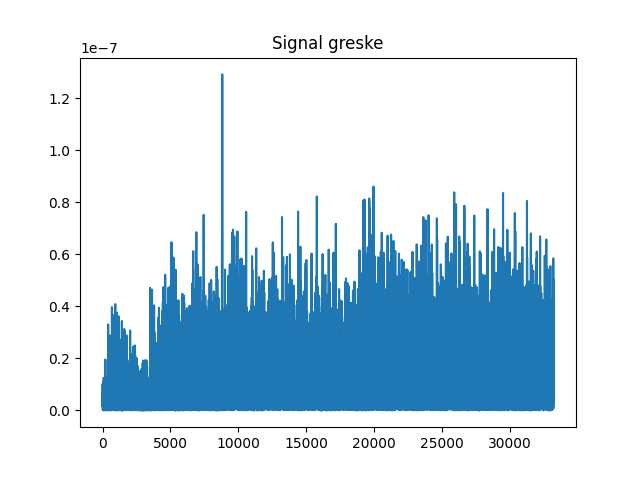

In [53]:
signal_error(acoustic_delay_with_feedback,acoustic_delay_with_feedback_c)

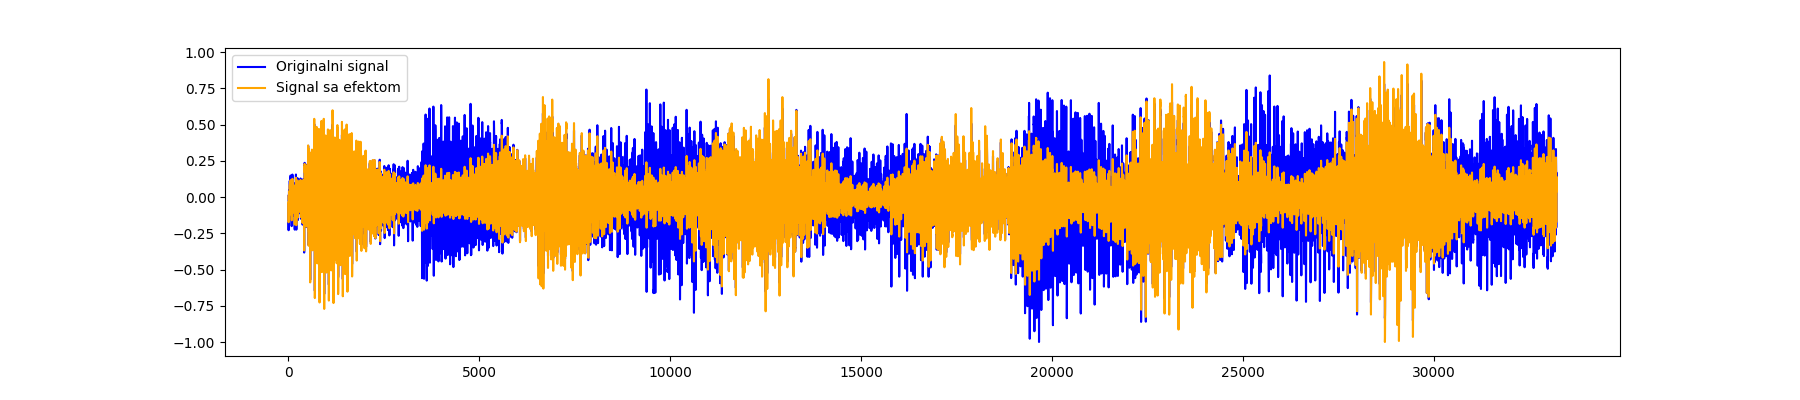

In [40]:
acoustic_tremolo =tremolo(input,samplerate,2,0.6,"acoustic_output_tremolo.wav")
plotSignals(input,acoustic_tremolo)
Audio(acoustic_tremolo,rate=samplerate)

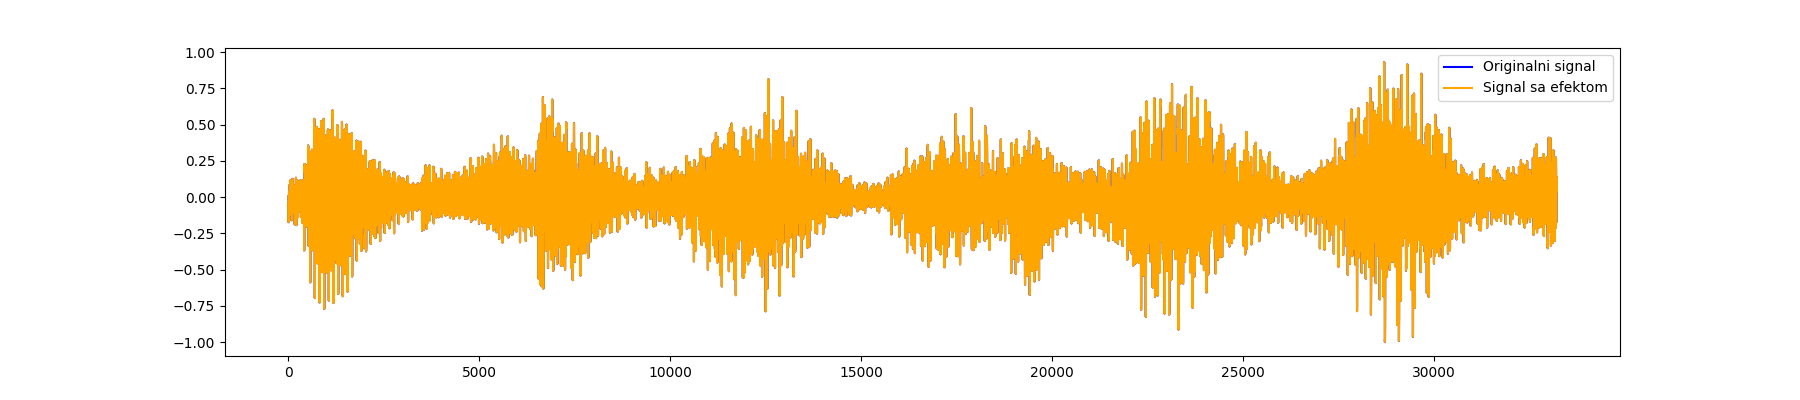

In [54]:
acoustic_tremolo_c = read_from_C("acoustic_output_tremolo_c.bin")
plotSignals(acoustic_tremolo,acoustic_tremolo_c)
Audio(acoustic_tremolo_c,rate=samplerate)

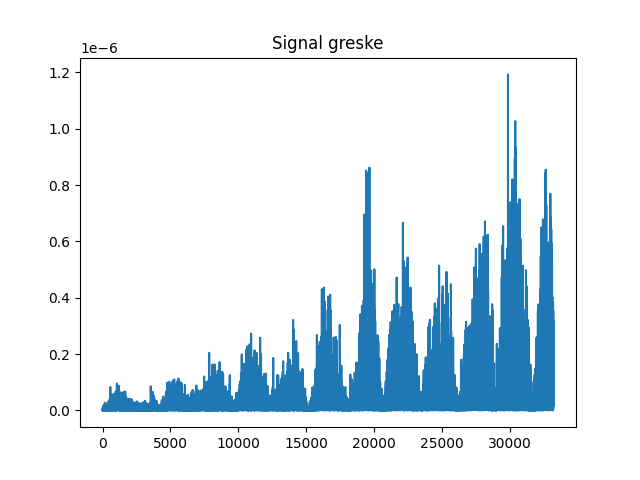

In [55]:
signal_error(acoustic_tremolo,acoustic_tremolo_c)

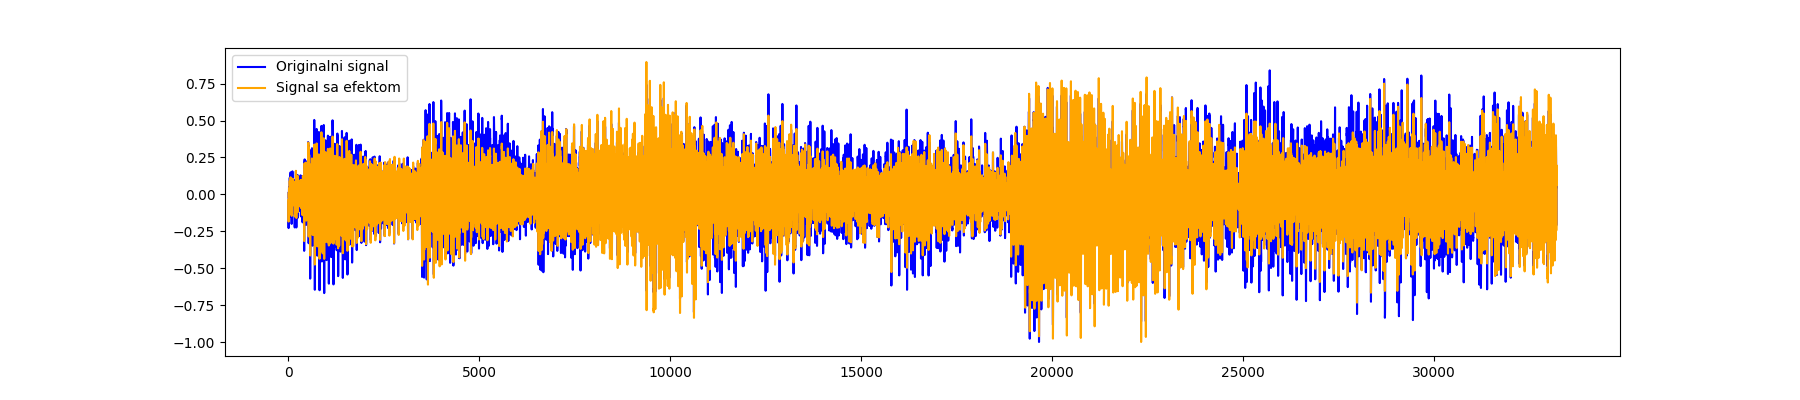

In [61]:
acoustic_flanger = flanger(input,samplerate,0.9,3,0.5,"acoustic_output_flanger.wav")
plotSignals(input,acoustic_flanger)
Audio(acoustic_flanger,rate=samplerate)

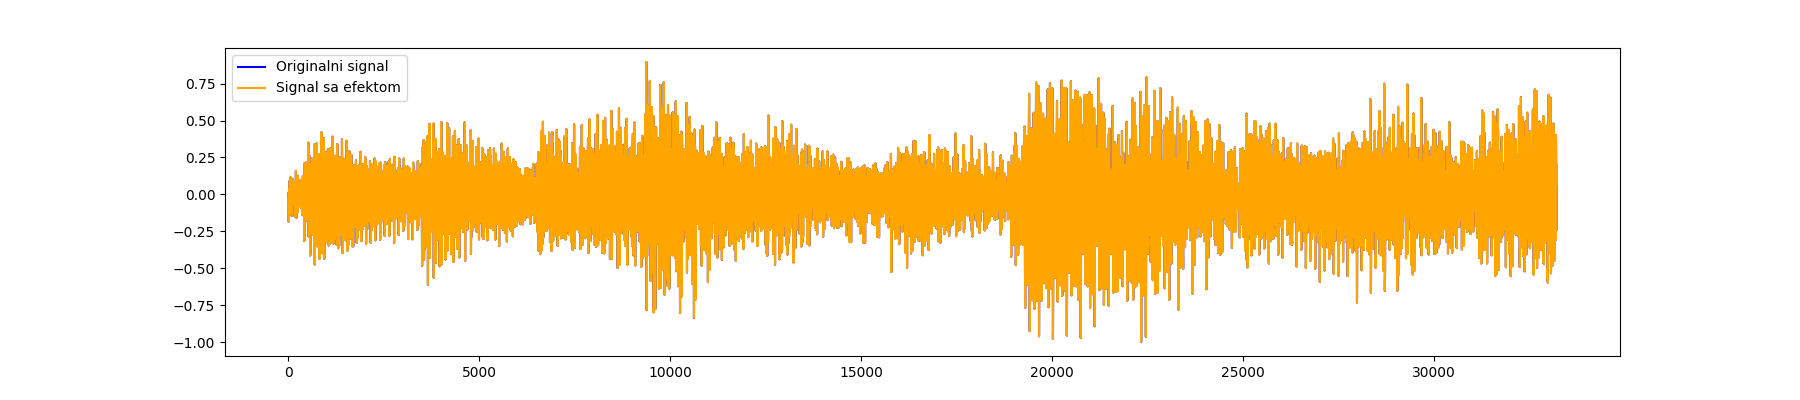

In [62]:
acoustic_flanger_c = read_from_C("acoustic_output_flanger_c.bin")
plotSignals(acoustic_flanger,acoustic_flanger_c)
Audio(acoustic_flanger_c,rate=samplerate)

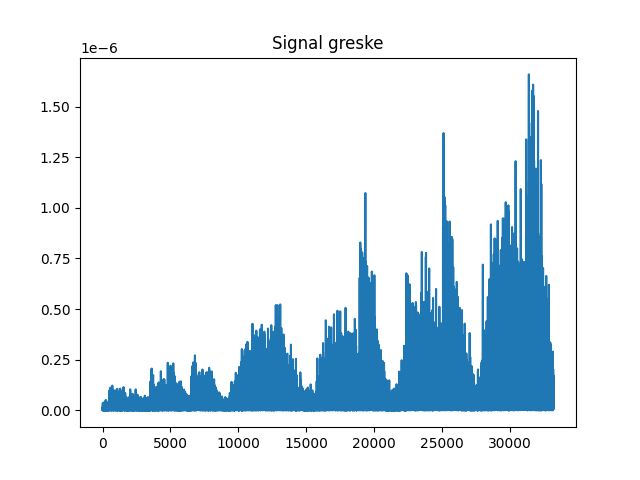

In [63]:
signal_error(acoustic_flanger,acoustic_flanger_c)

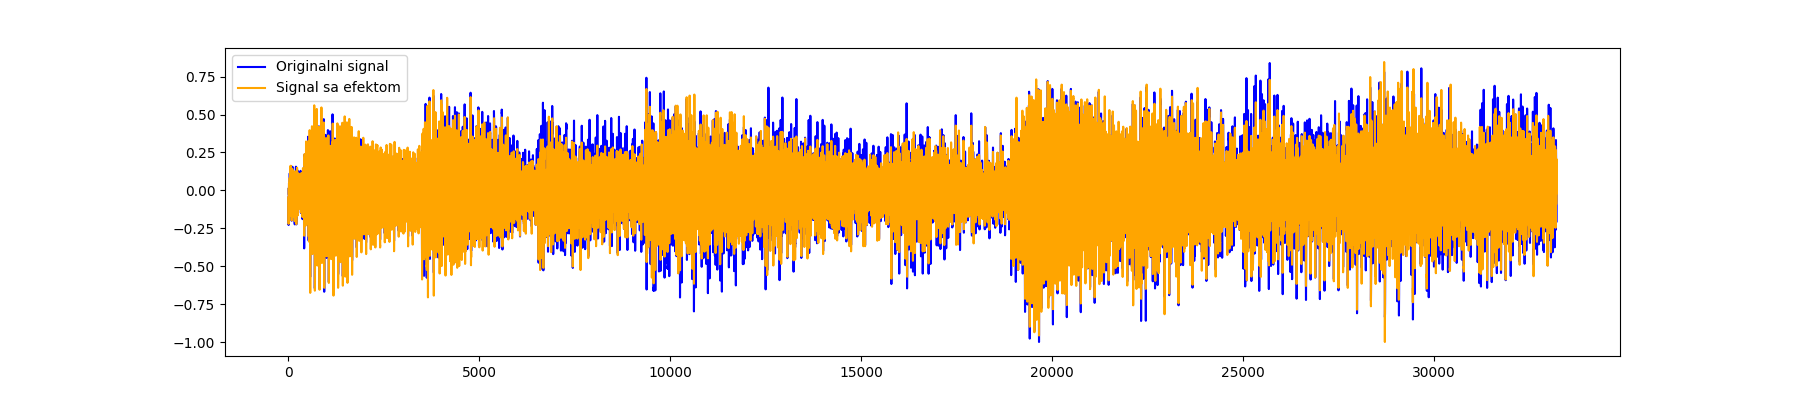

In [45]:
acoustic_flanger_feedback = flanger_with_feedback(input,samplerate,3,1,0.5,0.5,"acoustic_output_flanger_with_feedback.wav")
plotSignals(input,acoustic_flanger_feedback)
Audio(acoustic_flanger_feedback,rate=samplerate)

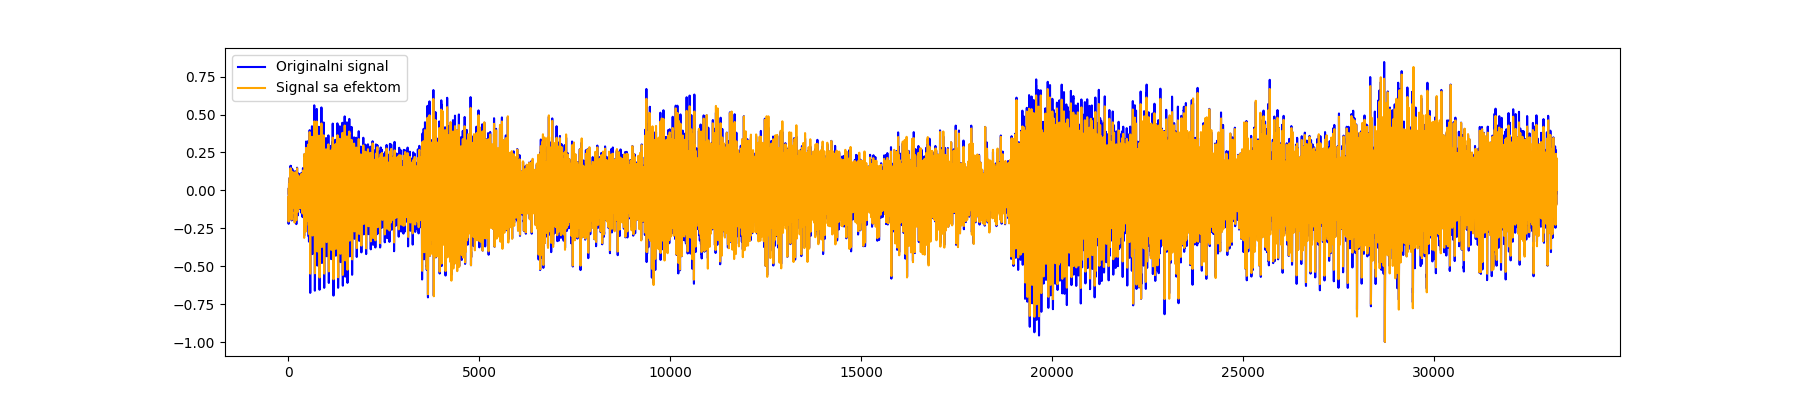

In [64]:
acoustic_flanger_feedback_c = read_from_C("acoustic_output_flanger_with_feedback_c.bin")
plotSignals(acoustic_flanger_feedback,acoustic_flanger_feedback_c)
Audio(acoustic_flanger_feedback_c,rate=samplerate)

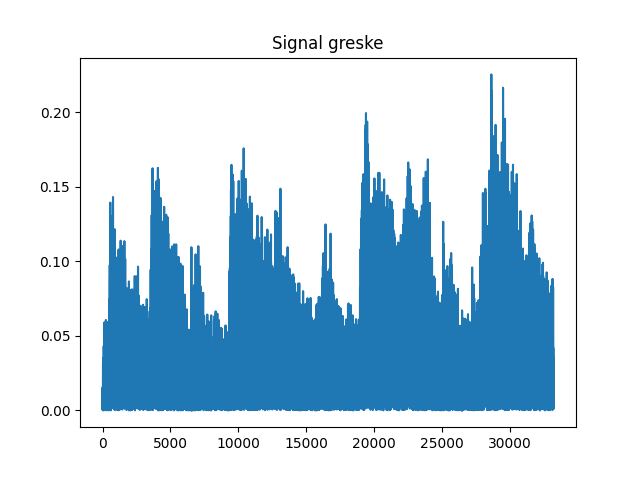

In [65]:
signal_error(acoustic_flanger_feedback,acoustic_flanger_feedback_c)

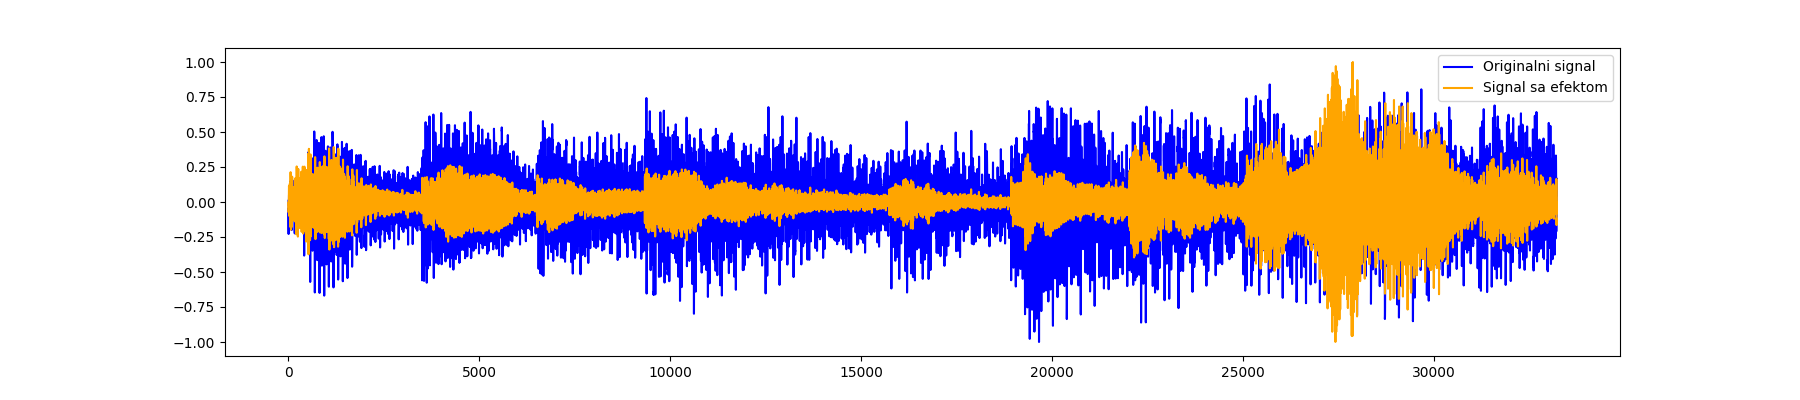

In [50]:
acoustic_wahwah = wahwah(input,"acoustic_output_wahwah.wav")
plotSignals(input,acoustic_wahwah)
Audio(acoustic_wahwah,rate=samplerate)


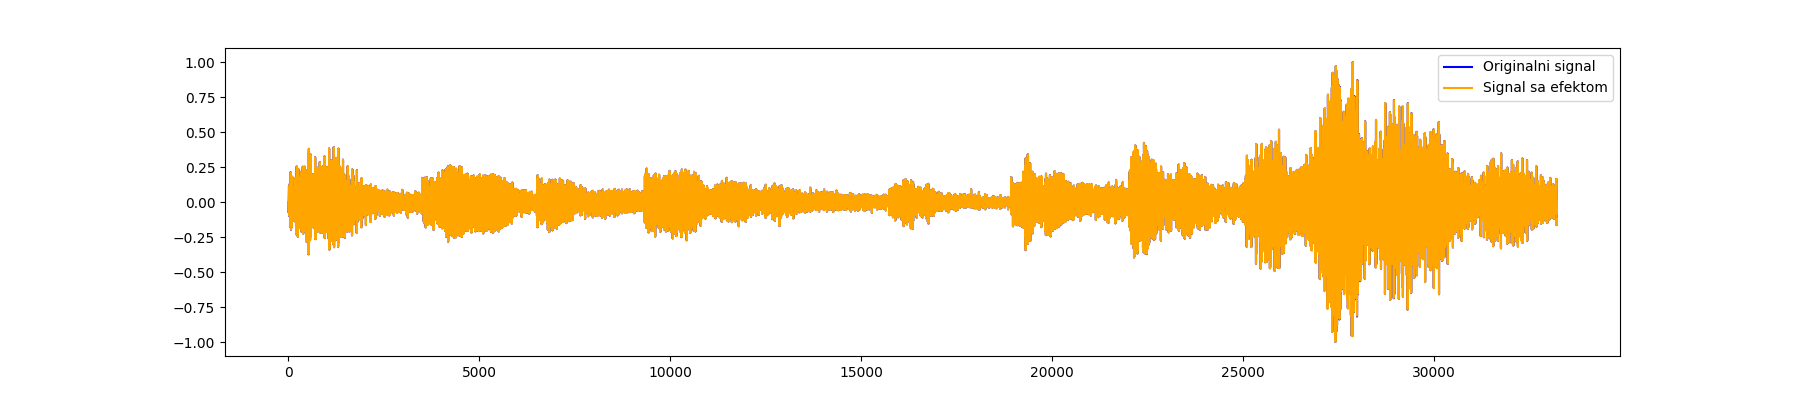

In [66]:
acoustic_wahwah_c = read_from_C("acoustic_output_wahwah_c.bin")
plotSignals(acoustic_wahwah,acoustic_wahwah_c)
Audio(acoustic_wahwah_c,rate=samplerate)

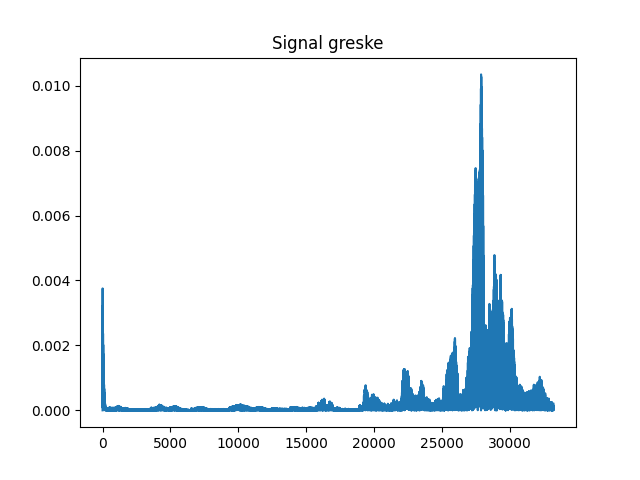

In [67]:
signal_error(acoustic_wahwah,acoustic_wahwah_c)